In [1]:
# imports
import socket
import random
from time import sleep
import datetime
import os
import boto3
from botocore.exceptions import NoCredentialsError

In [2]:
# create sample file
f= open("guru_desu.txt","w+")
for i in range(1):
     f.write("WATASHI WAWA DESU")
f.close() 

In [ ]:
rds = boto3.client('rds', region_name='eu-west-3')

role = get_execution_role()

region = boto3.Session(region_name='eu-west-3').region_name

s3 = boto.client

def upload_to_aws(local_file, bucket, s3_file):
    s3 = boto3.client('s3', aws_access_key_id=ACCESS_KEY,
                      aws_secret_access_key=SECRET_KEY)

    try:
        s3.upload_file(local_file, bucket, s3_file)
        print("Upload Successful")
        return True
    except FileNotFoundError:
        print("The file was not found")
        return False
    except NoCredentialsError:
        print("Credentials not available")
        return False


uploaded = upload_to_aws('guru_desu.txt', 'projetspark4iabd2ana', 'guru_desu.txt')

In [ ]:
# write simple string as folder in the S3 to test it

    print("\nX_train:",x_train.shape,"\n")
    print("\nX_valid:",x_valid.shape,"\n")
    train = x_train.to_csv (r'x_train.csv', index = None, header=False) #True avant mais bug
    valid = x_valid.to_csv (r'x_valid.csv', index = None, header=False) 
    
    
    #np.savetxt('data_train.csv', x_train, delimiter=',')        
    key_train = "{}/{}/train".format(prefix, 'train')
    key_test = "{}/{}/validation".format(prefix, 'validation')
    url_test = 's3n://{}/{}'.format(buckettest, key_test)
    url_train = 's3n://{}/{}'.format(buckettrain, key_train)
    boto3.Session().resource('s3').Bucket(buckettrain).Object(key_train).upload_file('x_train.csv')
    boto3.Session().resource('s3').Bucket(buckettest).Object(key_test).upload_file('x_valid.csv')
    print('Done writing test to {}'.format(url_test))
    print('Done writing train to {}'.format(url_train))


In [89]:
import os
import boto3
import re
import copy
import time
from time import gmtime, strftime
from sagemaker import get_execution_role
import sagemaker
import pickle, gzip, urllib.request, json 
import numpy as np 

from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

rds = boto3.client('rds', region_name='us-east-1')

role = get_execution_role()
region = boto3.Session(region_name='us-east-1').region_name
buckettrain = 'traindatasetgrozavu'
buckettest = 'testdatasetgrozavu'
prefix = 'sagemaker/xgboost-mnist2' # Used as part of the path in the bucket where you store data
# customize to your bucket where you will store data
buckettrain_path = 'https://s3-{}.amazonaws.com/{}'.format(region,buckettrain)
buckettrain_path = 'https://s3-{}.amazonaws.com/{}'.format(region,buckettest)

In [20]:
%%time 
# Load the dataset
column_names = ['class',
                'cap-shape',
                'cap-surface',
                'cap-color',
                'bruises',
                'odor',
                'gill-attachment',
                'gill-spacing',
                'gill-size',
                'gill-color',
                'stalk-shape',
                'stalk-root',
                'stalk-surface-above-ring',
                'stalk-surface-below-ring',
                'stalk-color-above-ring',
                'stalk-color-below-ring',
                'veil-type',
                'veil-color',
                'ring-number',
                'ring-type',
                'spore-print-color',
                'population',
                'habitat']

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
data = pd.read_csv(url, header=None, names=column_names)
lbl = LabelEncoder()

for col in data.columns:
    data[col]=lbl.fit_transform(data[col])
    
    
#split dataset to x and y (labels and vars)
y=data['class']
x=data.iloc[:,1:23]

print("x shape : ",x.shape)
print("y shape : ",y.shape)


x shape :  (8124, 22)
y shape :  (8124,)
CPU times: user 119 ms, sys: 8.61 ms, total: 128 ms
Wall time: 813 ms


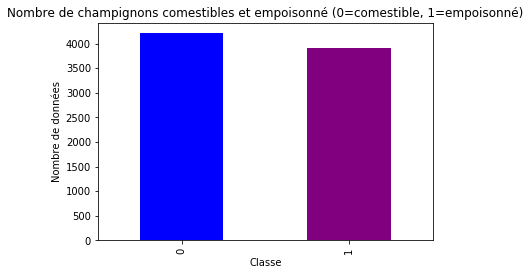

In [114]:
#Blanced Data ?
plt.figure()
pd.Series(y).value_counts().sort_index().plot(kind = 'bar', color=('blue', 'purple'))
plt.ylabel("Nombre de données")
plt.xlabel("Classe")
plt.title('Nombre de champignons comestibles et empoisonné (0=comestible, 1=empoisonné)');

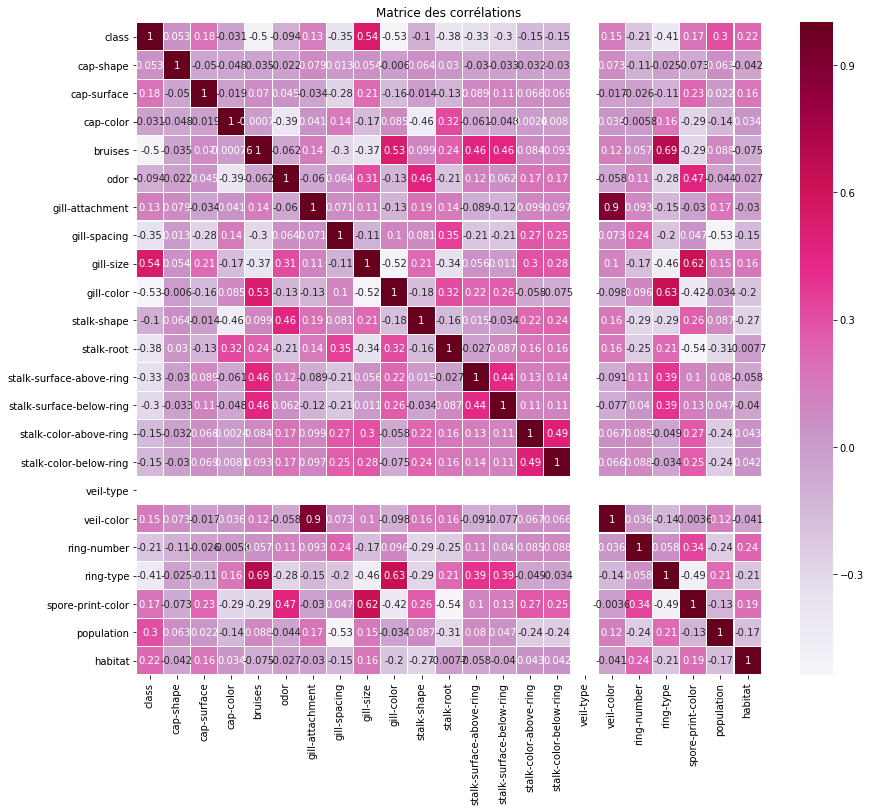

In [125]:
# correlated matrix
plt.figure(figsize=(14,12))
sns.heatmap(data.corr(),linewidths=.1,cmap="PuRd", annot=True)
plt.yticks(rotation=0);
plt.title('Matrice des corrélations');

In [ ]:
#split the dataset into a train and a validation set (80 - 20 %)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

#add y to datasets to publish the whole train / test into S3 buckets -> add as first col
x_train.insert(0, "label", y_train, True)
x_valid.insert(0, "label", y_valid, True)

#urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz") 
#with gzip.open('mnist.pkl.gz', 'rb') as f:    
#    train_set, valid_set, test_set = pickle.load(f, encoding='latin1') 
#    print(train_set[0].shape)
#    print(train_set)

In [21]:
#%matplotlib inline 
#plt.rcParams["figure.figsize"] = (2,10)
#for img, label in zip(train_set[0][:10], train_set[1][:10]):
#    img_reshape = img.reshape((28,28))
#    imgplot = plt.imshow(img_reshape, cmap='gray')
#    print('This is a {}'.format(label))
#    plt.show() 

In [22]:
%%time

import struct 
import io
import csv
import boto3

def convert_data():
    print("\nX_train:",x_train.shape,"\n")
    print("\nX_valid:",x_valid.shape,"\n")
    train = x_train.to_csv (r'x_train.csv', index = None, header=False) #True avant mais bug
    valid = x_valid.to_csv (r'x_valid.csv', index = None, header=False) 
    
    
    #np.savetxt('data_train.csv', x_train, delimiter=',')        
    key_train = "{}/{}/train".format(prefix, 'train')
    key_test = "{}/{}/validation".format(prefix, 'validation')
    url_test = 's3n://{}/{}'.format(buckettest, key_test)
    url_train = 's3n://{}/{}'.format(buckettrain, key_train)
    boto3.Session().resource('s3').Bucket(buckettrain).Object(key_train).upload_file('x_train.csv')
    boto3.Session().resource('s3').Bucket(buckettest).Object(key_test).upload_file('x_valid.csv')
    print('Done writing test to {}'.format(url_test))
    print('Done writing train to {}'.format(url_train))
        
convert_data()


X_train: (6499, 23) 


X_valid: (1625, 23) 

Done writing test to s3n://testdatasetgrozavu/sagemaker/xgboost-mnist2/validation/validation
Done writing train to s3n://traindatasetgrozavu/sagemaker/xgboost-mnist2/train/train
CPU times: user 293 ms, sys: 20.2 ms, total: 313 ms
Wall time: 466 ms


In [23]:
container = get_image_uri(region, 'xgboost', '0.90-1')
#container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [24]:
train_data = 's3://{}/{}/{}'.format(buckettrain, prefix, 'train') 
validation_data = 's3://{}/{}/{}'.format(buckettest, prefix, 'validation')
s3_output_location = 's3://{}/{}/{}'.format(buckettrain, prefix, 'xgboost_model_sdk') 
print(train_data)
print(validation_data)

s3://traindatasetgrozavu/sagemaker/xgboost-mnist2/train
s3://testdatasetgrozavu/sagemaker/xgboost-mnist2/validation


In [25]:
xgb_model = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    train_volume_size=5,           
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(boto_session=boto3.Session(region_name='us-east-1'))
)

In [26]:
xgb_model.set_hyperparameters(
    max_depth=5,
    eta=.2,
    gamma=4,
    min_child_weight=6,
    silent=0,
    objective="binary:logistic",
    #desactiver num class car binary
    #num_class=2,
    num_round=10
)

In [27]:
train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
valid_channel = sagemaker.session.s3_input(validation_data, content_type='text/csv')
data_channels = {'train': train_channel, 'validation': valid_channel}

In [106]:
xgb_model.fit(inputs=data_channels, logs=True)

AttributeError: 'Estimator' object has no attribute 'XGBClassifier'

In [29]:
#deploy model to sagemaker 
xgb_predictor = xgb_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------------!

In [122]:
print("xgb_model type ",xgb_model, "xgb predictor type = ", type(xgb_predictor))
#imp_vals = xgb.booster().get_fscore()
#print(xgb_model.plot_importance())
#get only data no labels of valid dataset
x_valid_data = x_valid.as_matrix()[:, 1:]

#default settings for predictor
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

#function to get predictions in numpy array
def predict(data, rows=1625):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')


predictions = predict(x_valid_data)
print("predicitons : ", predictions, "\ntype predictions : ", type(predictions), "\npredictions shape : ", predictions.shape, "\nprediction round : ", predictions.round())
print("\nvalid iloc 1 = ", x_valid.iloc[:, 0].values, "\nval iloc shape = ", x_valid.iloc[:, 0].values.shape, "\nval iloc type : ", type(x_valid.iloc[:, 0]))

print("\nAccuracy score : ", accuracy_score(x_valid.iloc[:, 0], predictions.round(), normalize=False) / x_valid.iloc[:, 0].shape[0])

#Create a roc curve and print auc score (get false positive rate, true positive rate and thresholds)
fpr, tpr, thresholds = roc_curve(x_valid.iloc[:, 0],predictions)
lr_auc = auc(fpr, tpr)
print("Good auc, the model has good predicts : ",lr_auc)

#print(xgb_predictor.features_importances_)
#print("Roc auc score : ", roc_auc_score(x_valid.iloc[:, 0], predictions.round()))


#print("\n test accu: ", accuracy_score(x_valid.iloc[:, 0], predictions.round(), normalize=False))

#print("test accu => ", float(np.sum(predictions==x_valid.iloc[:, 0])))
#accuracy = float(np.sum(predictions==x_valid.iloc[:, 0]) / x_valid.iloc[:, 0].shape[0])
#print("accu = %f" % (accuracy))
#print("test : ", x_valid.iloc[:, 0])


xgb_model type  <sagemaker.estimator.Estimator object at 0x7facb237e160> xgb predictor type =  <class 'sagemaker.predictor.RealTimePredictor'>
predicitons :  [0.93553936 0.06303099 0.09217561 ... 0.71898216 0.06303099 0.93553936] 
type predictions :  <class 'numpy.ndarray'> 
predictions shape :  (1625,) 
prediction round :  [1. 0. 0. ... 1. 0. 1.]

valid iloc 1 =  [1 0 0 ... 1 0 1] 
val iloc shape =  (1625,) 
val iloc type :  <class 'pandas.core.series.Series'>

Accuracy score :  0.9956923076923077
Good auc, the model has good predicts :  0.9998482926858869


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Comme on a pu le voir dans ce graphique, on presque pas de faux positifs


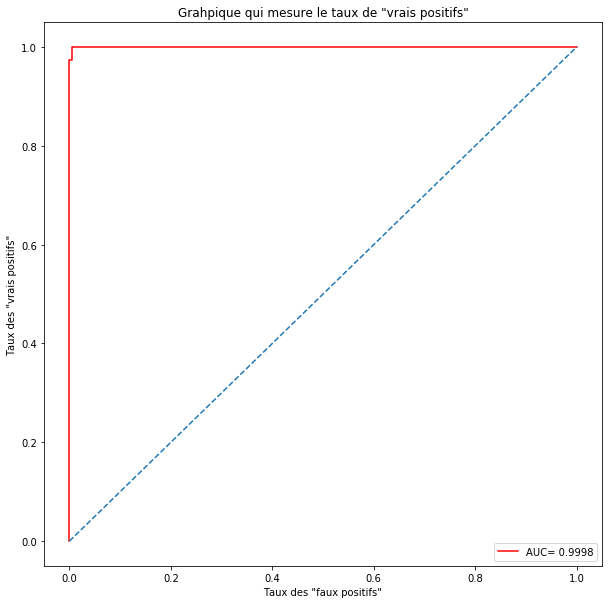

In [126]:
#plot the ROC curve
plt.figure(figsize=(10,10))
plt.title('Grahpique qui mesure le taux de \"vrais positifs\"')
plt.plot(fpr, tpr, color='red', label = 'AUC= ' + str(round(lr_auc, 4)))
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], linestyle = '--')
plt.axis('tight')
plt.ylabel('Taux des \"vrais positifs\"')
plt.xlabel('Taux des \"faux positifs\"')

print("Comme on a pu le voir dans ce graphique, on presque pas de faux positifs")

### VIEUX CODE

In [18]:
# get the def of the model
model_name = training_job_name + '-mod'

info = sm.describe_training_job(TrainingJobName=training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

NameError: name 'training_job_name' is not defined

In [17]:
#predicted values
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None
print(type(xgb_predictor$))
#xgb_predictor.predict(x_valid)

<class 'sagemaker.predictor.RealTimePredictor'>


In [ ]:
#import get image
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri 
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [ ]:
common_training_params = \
{
 "AlgorithmSpecification": {
 "TrainingImage": container,
 "TrainingInputMode": "File"
 },
 "RoleArn": role,
 "OutputDataConfig": {
 "S3OutputPath": bucket_path + "/"+ prefix + "/xgboost"
 },
 "ResourceConfig": {
 "InstanceCount": 1,
 "InstanceType": "ml.m4.xlarge",
 "VolumeSizeInGB": 5
 },
 "HyperParameters": {
 "max_depth":"5",
 "eta":"0.2",
 "gamma":"4",
 "min_child_weight":"6",
 "silent":"0",
 "objective": "multi:softmax",
 "num_class": "10",
 "num_round": "10"
 },
 "StoppingCondition": {
 "MaxRuntimeInSeconds": 86400
 },
 "InputDataConfig": [
 {
 "ChannelName": "train",
 "DataSource": {
 "S3DataSource": {
 "S3DataType": "S3Prefix",
 "S3Uri": bucket_path + "/"+ prefix+ '/train/',
 "S3DataDistributionType": "FullyReplicated"
 }
 },
 "ContentType": "text/csv",
 "CompressionType": "None"
 },
 {
 "ChannelName": "validation",
 "DataSource": {
 "S3DataSource": {
 "S3DataType": "S3Prefix",
 "S3Uri": bucket_path + "/"+ prefix+ '/validation/',
 "S3DataDistributionType": "FullyReplicated"
 }
 },
 "ContentType": "text/csv",
 "CompressionType": "None"
 }
 ]
}

In [ ]:
#training job params
training_job_name = 'xgboost-mnist' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", training_job_name)
training_job_params = copy.deepcopy(common_training_params)
training_job_params['TrainingJobName'] = training_job_name
training_job_params['ResourceConfig']['InstanceCount'] = 1

In [ ]:
%%time
region = boto3.Session().region_name
sm = boto3.Session().client('sagemaker')
sm.create_training_job(**training_job_params)
status = sm.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=training_job_name)
status = sm.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=training_job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

In [ ]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                instance_type='ml.t2.medium',
                                )

In [ ]:
model_name = training_job_name + '-mod'

info = sm.describe_training_job(TrainingJobName=training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

In [ ]:
endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

In [ ]:
%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)


----------------------7.1----------------------

In [ ]:
s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

In [ ]:
%matplotlib inline
                        
for i in range (0, 10):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

In [ ]:
runtime_client = boto3.client('runtime.sagemaker')

In [ ]:
with open('test_data', 'r') as f:
    
    for i in range(0,10):
        single_test = f.readline()
        response = runtime_client.invoke_endpoint(EndpointName = endpoint_name,
                                         ContentType = 'text/csv',
                                         Body = single_test)
        result = response['Body'].read().decode('ascii')
        print('Predicted label is {}.'.format(result))

------8 nettoyage sur la console AWS-------